This notebook adresseses a single machine scheduling problem. The objective studied is minimizing the makespan (completion time of latest job) on a single machine with sequence dependent setup times.

Each job is associated with a proccesing time, all jobs need to be processed on the single machine and preemption is not allowed.

The scheduling problem can be represented by 1|  $s_{i𝑗}$  | $C_{max}$  . This problem is known to be NP-hard. IBM ILOG CPLEX Optimization Studio includes solvers for both Mathematical and Constraint Programming. Constraint Programming is particularly efficient and useful to tackle detailed scheduling problems. By using docplex.cp python package, you can easily formulate and solve scheduling problems in python notebooks. Below is an example formulation with randomly generated sample data to provide a better understanding of the problem and the model.

In [1]:
nbrOfJobs = 10
jobs = [*range(0, nbrOfJobs)] 

In [2]:
#generate sequence dependent setup times
import numpy as np
import random
setup_matrix = np.zeros(shape=(nbrOfJobs,nbrOfJobs))
for i in jobs:
    for j in jobs:
        if i!=j:
            setup_matrix[i][j] = random.randint(6,15);
setup_matrix = setup_matrix.astype(int)
print(setup_matrix)

[[ 0  8 10 10 11 15  9  6  7  7]
 [10  0 10  8 15 15 15  8 13 13]
 [11 10  0 14 10 15  6  9  9 12]
 [13 11  6  0  6 10  7  9  7 13]
 [13 15  9 13  0 11 12 14  9  9]
 [14 11 13 15  6  0 12 13  9  7]
 [11  6 15 11  9 14  0 15  9 12]
 [14  7 12 11 14  7 10  0 12 12]
 [ 6 13  6  9 15  9 12  6  0 15]
 [ 7  9 13  7 14  7  7  8  7  0]]


In [3]:
minProcessingTime=10
maxProcessingTime=40
processingTimes = [random.randint(minProcessingTime, maxProcessingTime) for j in jobs]
print(processingTimes)

[33, 31, 21, 20, 25, 36, 25, 14, 21, 23]


In [4]:
from docplex.cp.model import *
mdl = CpoModel(name='singleMachineScheduling') 

In [5]:
# define production processing interval of each job at each machine
processing_itv_vars = [mdl.interval_var(size=processingTimes[j], name="interval_job{}".format(j)) for j in jobs] 
for j in jobs:
    print(processing_itv_vars[j])

interval_job0 = intervalVar(size=33)
interval_job1 = intervalVar(size=31)
interval_job2 = intervalVar(size=21)
interval_job3 = intervalVar(size=20)
interval_job4 = intervalVar(size=25)
interval_job5 = intervalVar(size=36)
interval_job6 = intervalVar(size=25)
interval_job7 = intervalVar(size=14)
interval_job8 = intervalVar(size=21)
interval_job9 = intervalVar(size=23)


In [6]:
#minimize makespan
objective = mdl.max([mdl.end_of(processing_itv_vars[j]) for j in jobs])
mdl.add(mdl.minimize(objective)) 

In [7]:
#Sequencing and No Overlap constraints
sequence_vars = mdl.sequence_var([processing_itv_vars[j] for j in jobs] , types = [j for j in jobs], name = "sequences")
mdl.add(mdl.no_overlap(sequence_vars,setup_matrix,is_direct=True))

In [8]:
msol= mdl.solve(log_output=True,TimeLimit=60)

In [9]:
print("Solution: ")
msol.print_solution()

Solution: 
-------------------------------------------------------------------------------
Model constraints: 1, variables: integer: 0, interval: 10, sequence: 1
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 1.82 sec
-------------------------------------------------------------------------------
Objective values: (308,), bounds: (308,), gaps: (0,)
interval_job0: (start=0, end=33, size=33, length=33)
interval_job1: (start=218, end=249, size=31, length=31)
interval_job2: (start=160, end=181, size=21, length=21)
interval_job3: (start=257, end=277, size=20, length=20)
interval_job4: (start=283, end=308, size=25, length=25)
interval_job5: (start=60, end=96, size=36, length=36)
interval_job6: (start=187, end=212, size=25, length=25)
interval_job7: (start=39, end=53, size=14, length=14)
interval_job8: (start=133, end=154, size=21, length=21)
interval_job9: (start=103, end=126, size=23, length=23)
seq

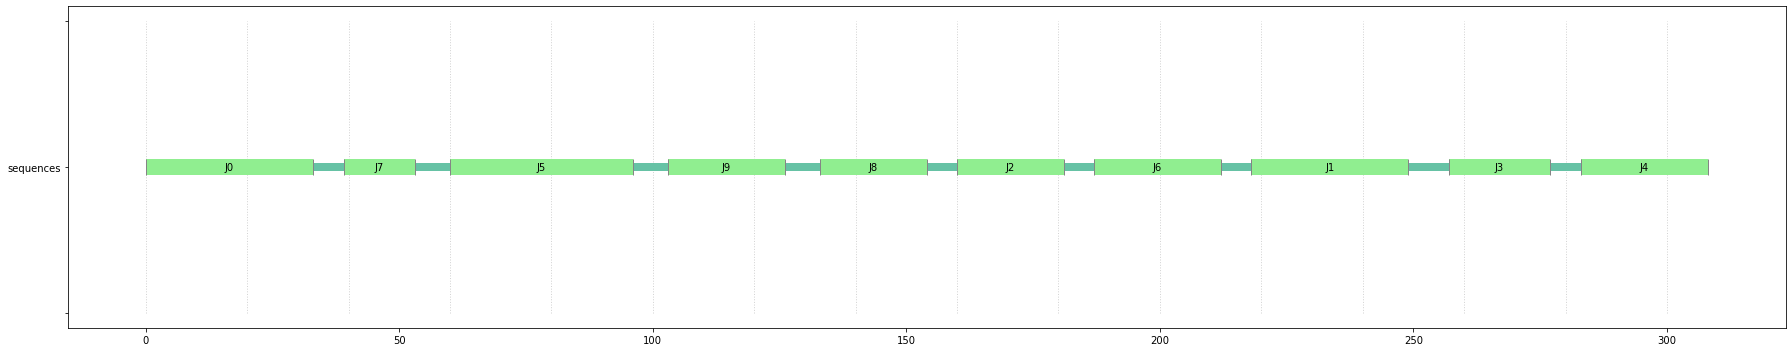

In [10]:
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
%matplotlib inline
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5

# Build a map to retrieve task id from variable name (for display purpose)
job_id = dict()
for j in jobs:
    nm=processing_itv_vars[j].get_name()
    job_id[processing_itv_vars[j].get_name()] = j

seq = msol.get_var_solution(sequence_vars)

visu.timeline("Solution Schedule")    
visu.sequence(name=sequence_vars.get_name())
vs = seq.get_value()
for v in vs:
    nm = v.get_name()
    visu.interval(v, 'lightgreen' , 'J' + str(job_id[nm]))
for j in range(len(vs) - 1):
    end = vs[j].get_end()
    j1 = job_id[vs[j].get_name()]
    j2 = job_id[vs[j + 1].get_name()]
    visu.transition(end, end + setup_matrix[j1][j2])
visu.show()